In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lung-and-colon-cancer-histopathological-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F601280%2F1079953%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T143729Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D191a59b39148d6e248458531c3a473b78b5e575c718b790f47aa2cc5c27f9d8dd7c86b742d95b47fe673fe225f8ef21ba81a68859cf9a6b074a8931030f7da0975c18b6776301222d71f8fe985e218be4ca7f1b65d1387c7a87c1bdf5b0dc0e6fcd9057bb00b5e28f0d3bd292455ed33981f7227c8f929016757726eeb6f7bf0dcb8626410b9d84502176813b913f8e86ee001697721f50e1fde0a33cc68b295028b6d09cc39650cf47b7d5c1c69aba5cf0e17504859a2c447efb6d3f9313de9b168661b748cec696c5e475d2b4dcf5b566c176c42fd5c3efd61edb105ef06574a47b49834bd67a91d3ec3e2095870a4858610b9cb0ffafdfe0d0af0cc2deb4f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1889364933 bytes downloaded
Downloaded and uncompressed: lung-and-colon-cancer-histopathological-images
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, DepthwiseConv2D, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

## Generating label-file path data frame

In [ ]:
data = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

path = []
labels = []

folders = os.listdir(data)

for folder in folders:
    folderpath = os.path.join(data, folder)
    sub_folders = os.listdir(folderpath)

    for sub_folder in sub_folders:
        sub_filepath = os.path.join(folderpath,sub_folder)
        files = os.listdir(sub_filepath)

        for file in files:
            file_path = os.path.join(sub_filepath, file)
            path.append(file_path)

            if sub_folder == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif sub_folder == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif sub_folder == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif sub_folder == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif sub_folder == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

Fseries = pd.Series(path, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df.sample(6)

filepaths  \
17480  /kaggle/input/lung-and-colon-cancer-histopatho...   
8749   /kaggle/input/lung-and-colon-cancer-histopatho...   
10911  /kaggle/input/lung-and-colon-cancer-histopatho...   
20700  /kaggle/input/lung-and-colon-cancer-histopatho...   
1026   /kaggle/input/lung-and-colon-cancer-histopatho...   
24305  /kaggle/input/lung-and-colon-cancer-histopatho...   

                             labels  
17480          Colon Adenocarcinoma  
8749            Lung Adenocarcinoma  
10911            Lung Benign Tissue  
20700           Colon Benign Tissue  
1026   Lung Squamous Cell Carcinoma  
24305           Colon Benign Tissue

## Split the data

Use 'stratify' to keep the proportion of classes same in each split

In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

### Now read the images from the paths by making data generator

In [ ]:
batch_size = 64
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


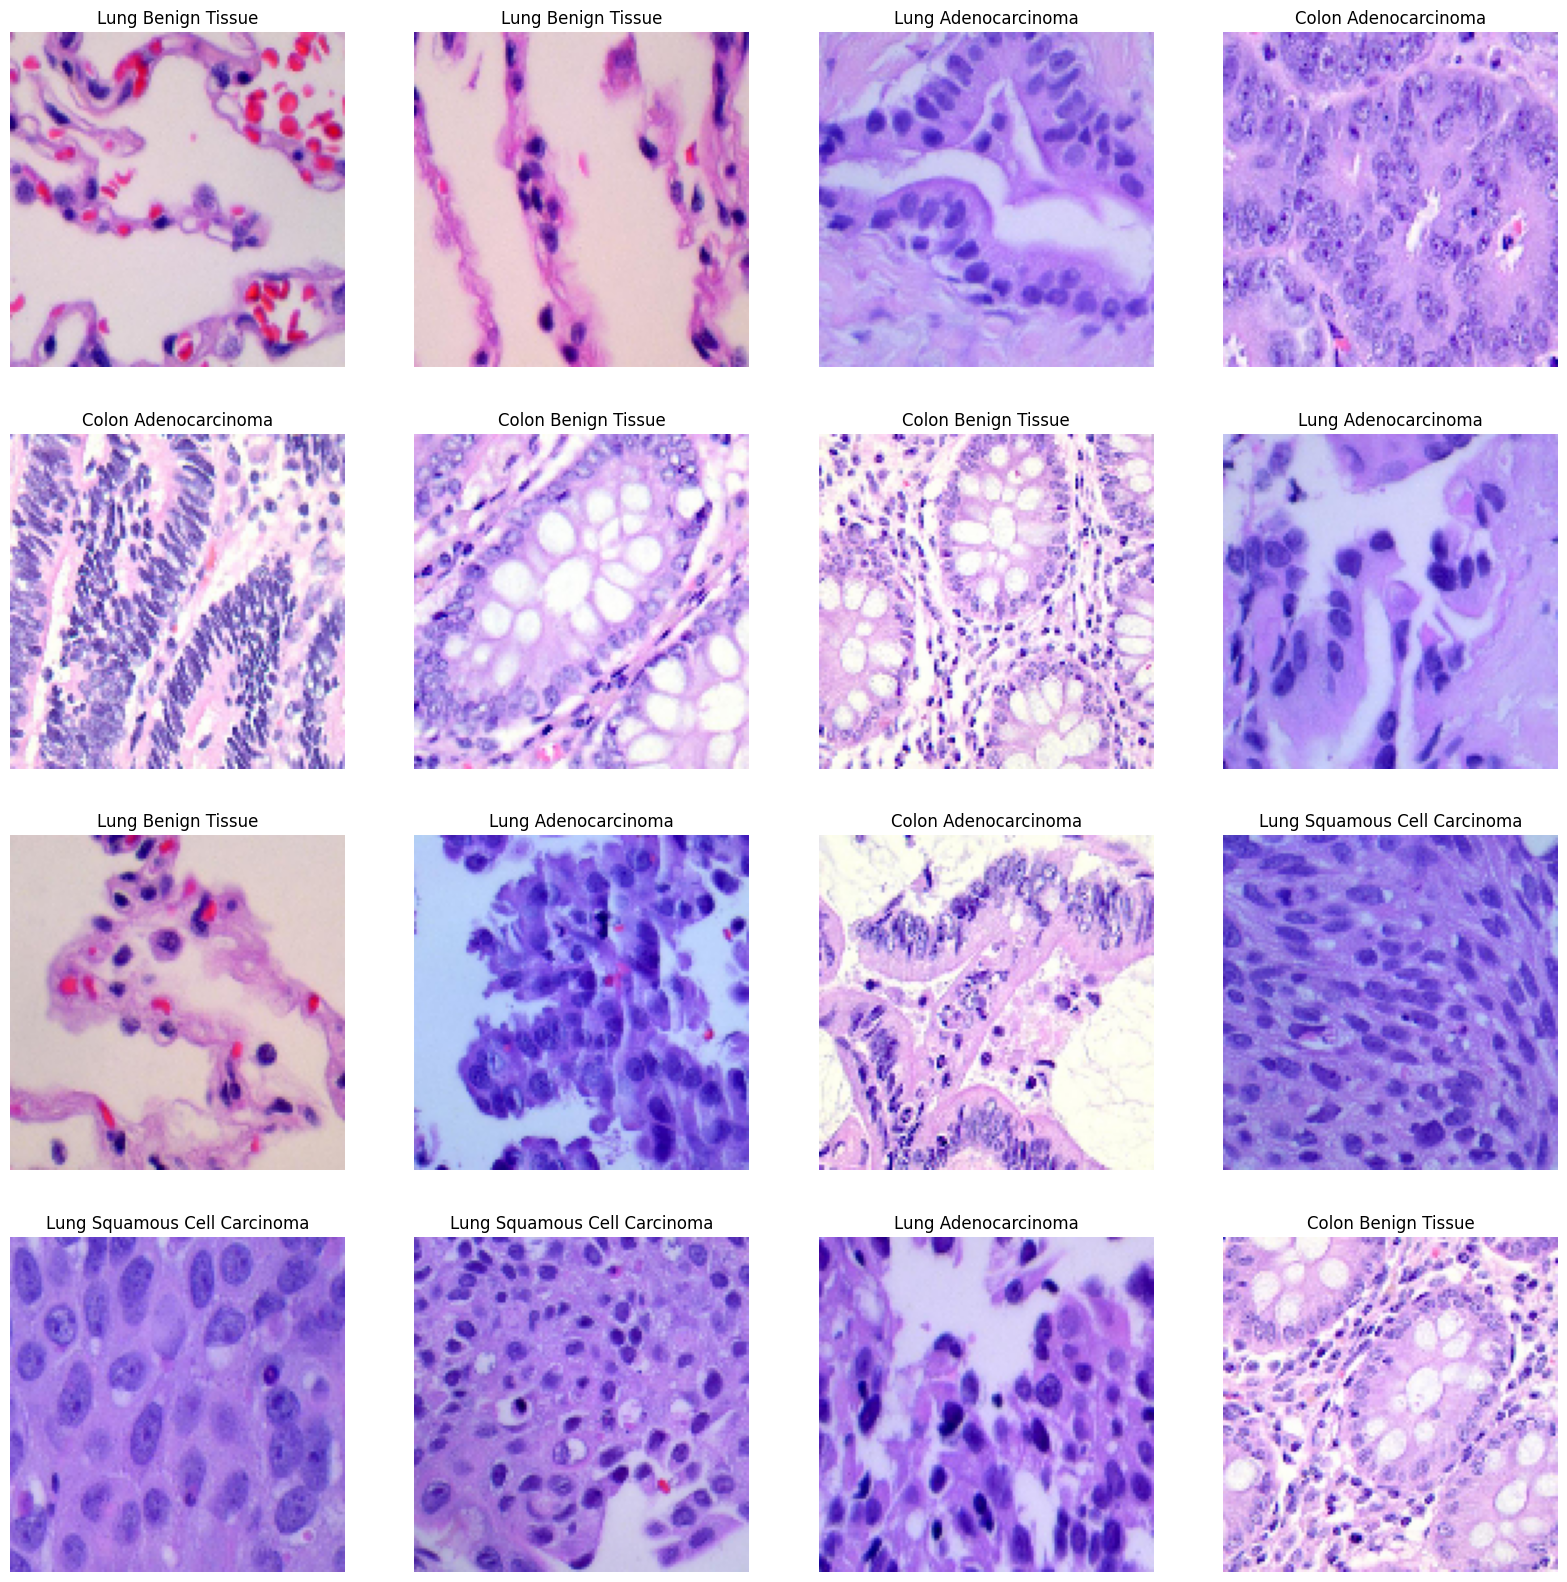

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# labels in one hot vector

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get the index of class
    plt.title(classes[index], fontsize= 12)
    plt.axis('off')
plt.show()

## Model

In [ ]:
# Create Model Structure
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
p_drop = 0.3

model2 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=64, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=256, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    Dropout(p_drop),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=512, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),

    Conv2D(filters=512, kernel_size=(1,1), padding="same", activation="relu"),
    Dropout(p_drop),
    MaxPooling2D((2, 2)),
    Conv2D(filters=512, kernel_size=(1,1), padding='same', activation="relu"),
    Dropout(p_drop),
    Conv2D(filters=512, kernel_size=(1,1), padding="same", activation="relu"),
    Dropout(p_drop),
    MaxPooling2D((2, 2)),
    Conv2D(filters=512, kernel_size=(1,1), padding='same', activation="relu"),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),

    Flatten(),
    Dense(512,activation = "relu"),
    Dropout(p_drop),
    Dense(256,activation = "relu"),
    Dropout(p_drop),
    Dense(128,activation = "relu"),
    Dropout(p_drop),

    Dense(64),
    BatchNormalization(),
    ReLU(),
    Dropout(p_drop),
    Dense(class_count, activation = "softmax")
])

In [ ]:
model2.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 128, 128, 64)      640       
 eConv2D)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0

In [ ]:
model2.load_weights('weights_0)Adamax.weights.h5')

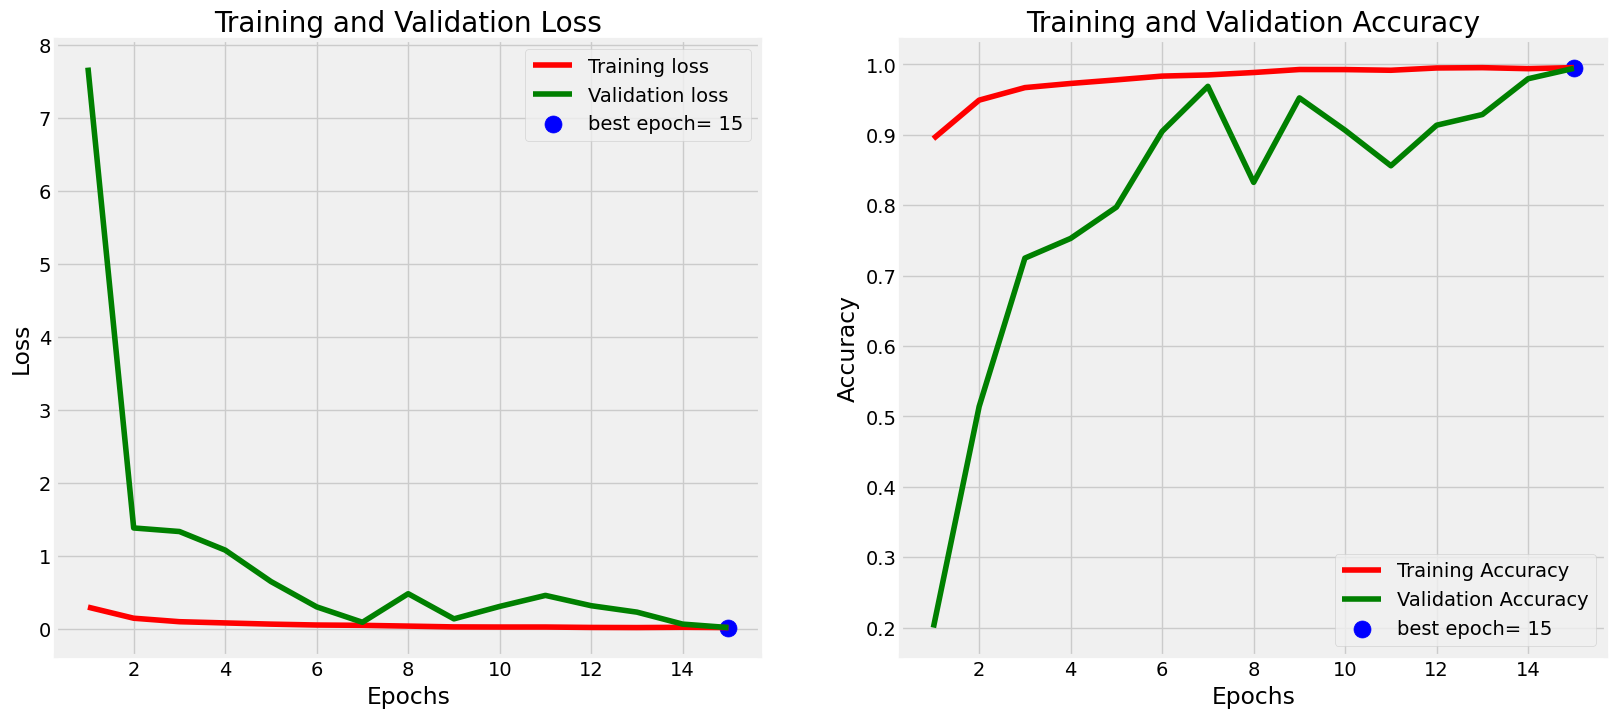

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model2.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model2.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model2.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.9979 - loss: 0.0082
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.9895 - loss: 0.0241
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9948 - loss: 0.0151
Train Loss:  0.010115524753928185
Train Accuracy:  0.996874988079071
--------------------
Valid Loss:  0.020778976380825043
Valid Accuracy:  0.991599977016449
--------------------
Test Loss:  0.015059025958180428
Test Accuracy:  0.9944000244140625


In [ ]:
batch_size = 100
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen1 = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen1 = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen1 = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
preds = model2.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 2/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

W0000 00:00:1722106107.419349     197 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step


W0000 00:00:1722106119.993618     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


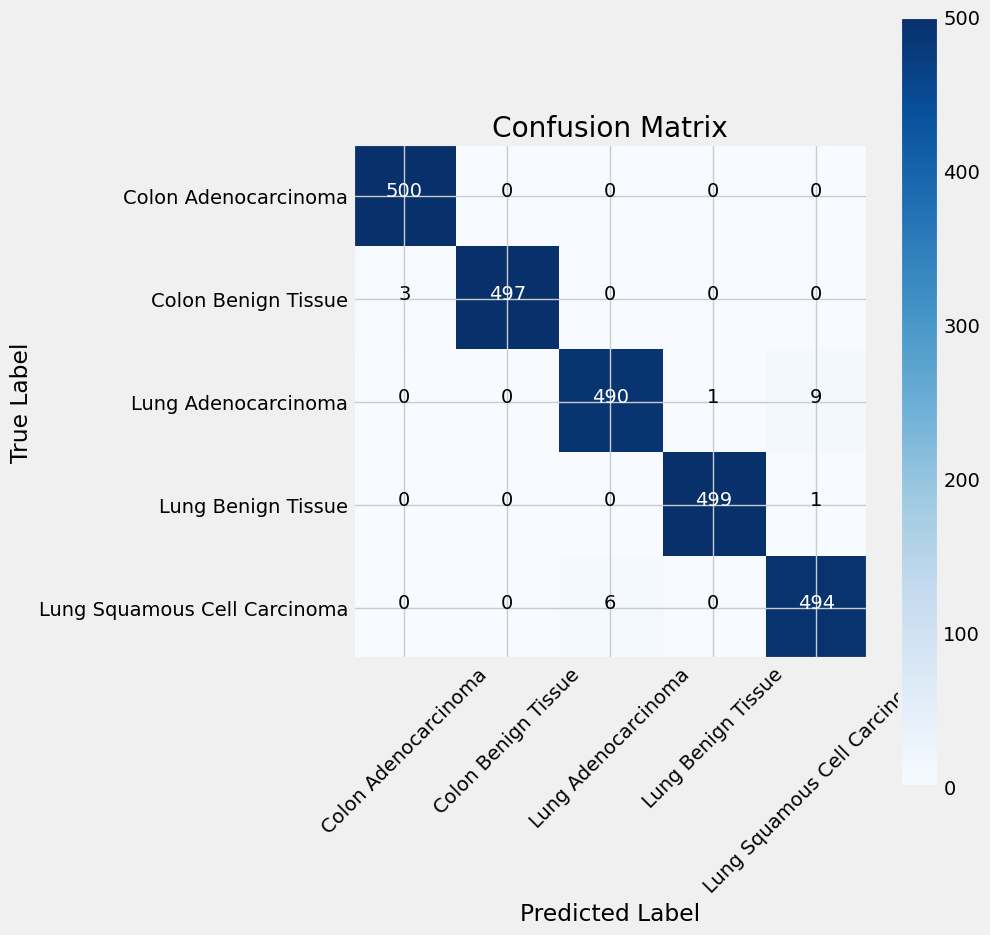

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      1.00      1.00       500
         Colon Benign Tissue       1.00      0.99      1.00       500
         Lung Adenocarcinoma       0.99      0.98      0.98       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.98      0.99      0.98       500

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500



Test

In [ ]:
image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
image = Image.open(image_path)

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")